# Context :

## Mental Arithmetic EEG Dataset (36 subjects)

**Source Kaggle + PhysioNet (BIDS format)**

Objectif du dataset
Étudier les modifications de l’activité cérébrale (via EEG) lors de tâches cognitives impliquant une charge mentale élevée (séries de soustractions mentales). Ce dataset est utile pour :

- **la détection de stress cognitif**
- **la classification d'état mental (repos vs activité mentale)**
- les modèles de charge mentale ou de BCI (interfaces cerveau-machine)
- **la génération de connectomes EEG (cohérence, wPLI, etc.)**

## Méthode expérimentale
| Élément                     | Détail                                                                 |
|----------------------------|------------------------------------------------------------------------|
| Nombre de sujets            | 36 (étudiants en biologie / psychologie, âge moyen : 18,6 ans)         |
| Périodes enregistrées       | 3 minutes de repos + 1 minute d’activité mentale                       |
| Tâche cognitive             | Soustraction mentale de 2 nombres (ex : 3141 - 42)                     |
| Environnement               | Chambre sombre insonorisée, yeux fermés pendant l’enregistrement       |
| Position des électrodes     | Norme internationale 10/20  --> positions (Fp1, Fp2, F3, F4, F7, F8, T3, T4, ..., Pz) – 19 canaux au total |
| Matériel EEG                | Neurocom 23-channel system (XAI-MEDICA, Ukraine)                       |
| Fréquence d’échantillonnage | 500 Hz                                                                 |
| Filtrage                    | 0.5–45 Hz + notch 50 Hz + ICA (=Analyse en Composantes Indépendantes -> pour retirer les artéfacts)             |


# Description des fichiers (sur Kaggle)
https://www.kaggle.com/datasets/amananandrai/complete-eeg-dataset#

On dispose de 36 fichiers .csv, chacun correspondant à un sujet, avec :

- Colonnes : 19 canaux EEG standards (Fp1, Fp2, F3, ..., Pz)
- Lignes : ~30 000 points (soit 60 secondes à 500 Hz)


# Groupes de performance mentale
Les 36 sujets sont classés en deux groupes :

- G (Good counters, 24 sujets) : moyenne ≈ 21 opérations
- B (Bad counters, 12 sujets) : moyenne ≈ 7 opérations

Ce classement se trouve dans un fichier participants.tsv dans la version BIDS (PhysioNet), mais il n’est pas présent dans la version Kaggle. Il faudra l’ajouter à la main si nécessaire pour une tâche de classification supervisée.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import seaborn as sns
import os
import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import plotly.graph_objects as go

from mne_connectivity import spectral_connectivity_epochs


# Lecture du dataset

In [2]:
csv_path = "../data/dataset/MATH_EEG/s00.csv"

columns = [
    "Fp1", "Fp2", "F3", "F4", "F7", "F8", "T3", "T4",
    "C3", "C4", "T5", "T6", "P3", "P4", "O1", "O2",
    "Fz", "Cz", "Pz"
]

df = pd.read_csv(csv_path, names=columns)

df.head()


,Fp1,Fp2,F3,F4,F7,F8,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
0,4.4760,-2.7403,-2.5017,0.095121,-7.0917,-0.42704,-2.5918,-3.3238,0.999500,0.87011,-0.080058,2.8075,-0.52398,1.93410,-3.7614,-1.1440,0.033687,2.7164,0.84831
1,1.2080,-3.3088,-4.4178,-0.529350,-8.5782,0.40699,-3.0996,-3.6005,-0.048363,-0.17258,-0.129650,3.2872,-1.06670,1.53570,-5.1933,-2.2263,-0.682180,4.8287,0.45261
2,-2.5460,-3.7083,-6.4109,-1.003300,-10.2200,1.87700,-3.6952,-3.8673,-1.132300,-1.32850,-0.094006,3.9756,-1.67430,1.12850,-6.5565,-3.0953,-1.284400,6.6513,-0.10393
3,-6.1871,-3.6804,-8.0297,-1.103100,-11.7210,4.01570,-4.2652,-4.0530,-1.984100,-2.36070,0.076473,4.8331,-2.22930,0.79364,-7.4787,-3.4209,-1.540900,7.6371,-0.74250
4,-9.1110,-3.0027,-8.8444,-0.651400,-12.7840,6.71770,-4.6708,-4.0965,-2.337200,-3.02550,0.401930,5.7805,-2.61450,0.58741,-7.6430,-2.9829,-1.248700,7.4512,-1.32640


# On trace les signaux

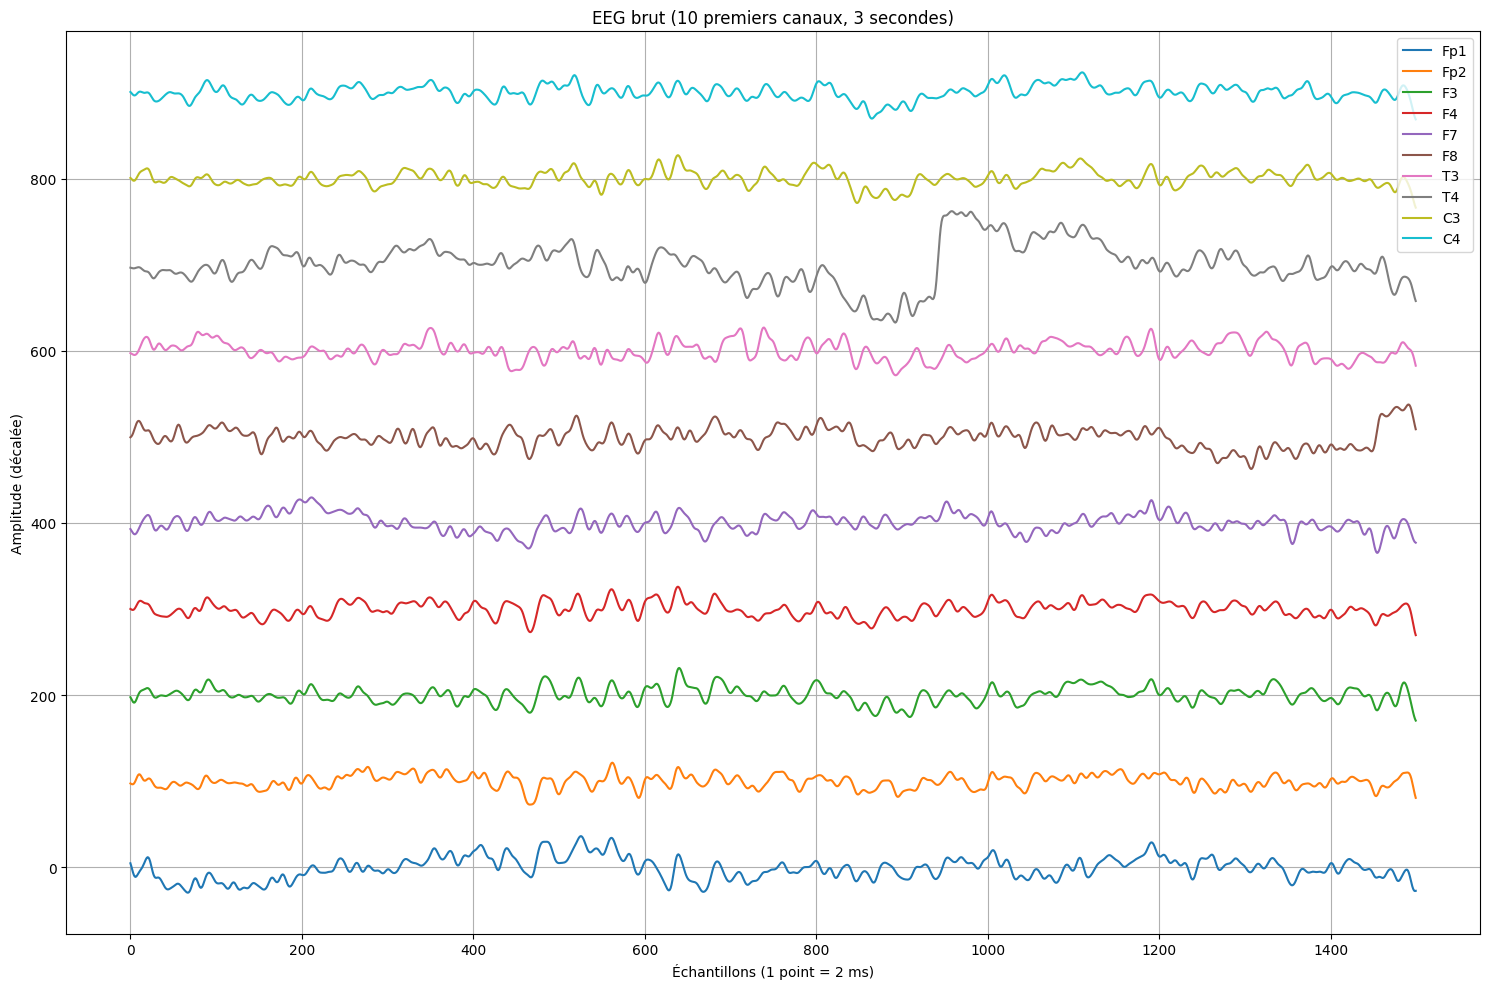

In [3]:
# Paramètres d'affichage
n_seconds = 3
sampling_rate = 500
n_points = n_seconds * sampling_rate

plt.figure(figsize=(15, 10))

# Afficher les 10 premiers canaux
for i, column in enumerate(df.columns[:10]):
    signal = df[column][:n_points]
    plt.plot(signal + i * 100, label=column)  # Décalage vertical pour lisibilité

plt.title(f"EEG brut (10 premiers canaux, {n_seconds} secondes)")
plt.xlabel("Échantillons (1 point = 2 ms)")
plt.ylabel("Amplitude (décalée)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualization d'un canal individuel

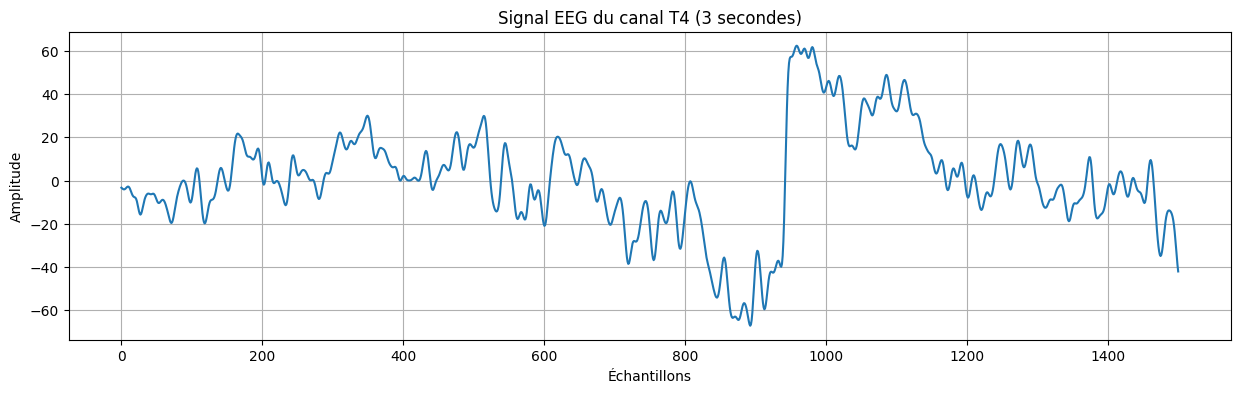

In [4]:
channel = "T4"  
signal = df[channel]

plt.figure(figsize=(15, 4))
plt.plot(signal[:1500])
plt.title(f"Signal EEG du canal {channel} ({n_seconds} secondes)")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


# Commençons à voir comment faire un connectome ...
infos utiles : https://connectome-mapper-3.readthedocs.io/en/v3.2.0/api/generated/cmp.pipelines.functional.eeg.html

### Étape 1 : Filtrer nos signaux en bandes de fréquences comme dans l'article : 

| Bande | Plage de fréquence (Hz) | Interprétation                       |
| ----- | ----------------------- | ------------------------------------ |
| Delta | 0.5 – 4                 | Sommeil profond                      |
| Theta | 4 – 8                   | Sommeil léger, méditation            |
| Alpha | 8 – 13                  | Calme, relaxation                    |
| Beta  | 13 – 30                 | Activité mentale, alerte             |
| Gamma | 30 – 45 (ou 50)         | Cognition élevée, attention soutenue |

--> Filtre passe-bande Butterworth

In [5]:
sampling_rate = 500  # Hz

# ---- Fonction -----
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Applique un filtre passe-bande (Filtre de Butterwhorth) à un signal EEG.

    :param data: Signal EEG brut
    :param lowcut: Fréquence de coupure inférieure (Hz)
    :param highcut: Fréquence de coupure supérieure (Hz)
    :param fs: Fréquence d'échantillonnage (Hz)
    :param order: Ordre du filtre
    :return: Signal EEG filtré
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# ---- Application ----
channel = "T4"
signal = df[channel].values

# ---- Bandes de fréquence souhaitées ----
bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 45)
}


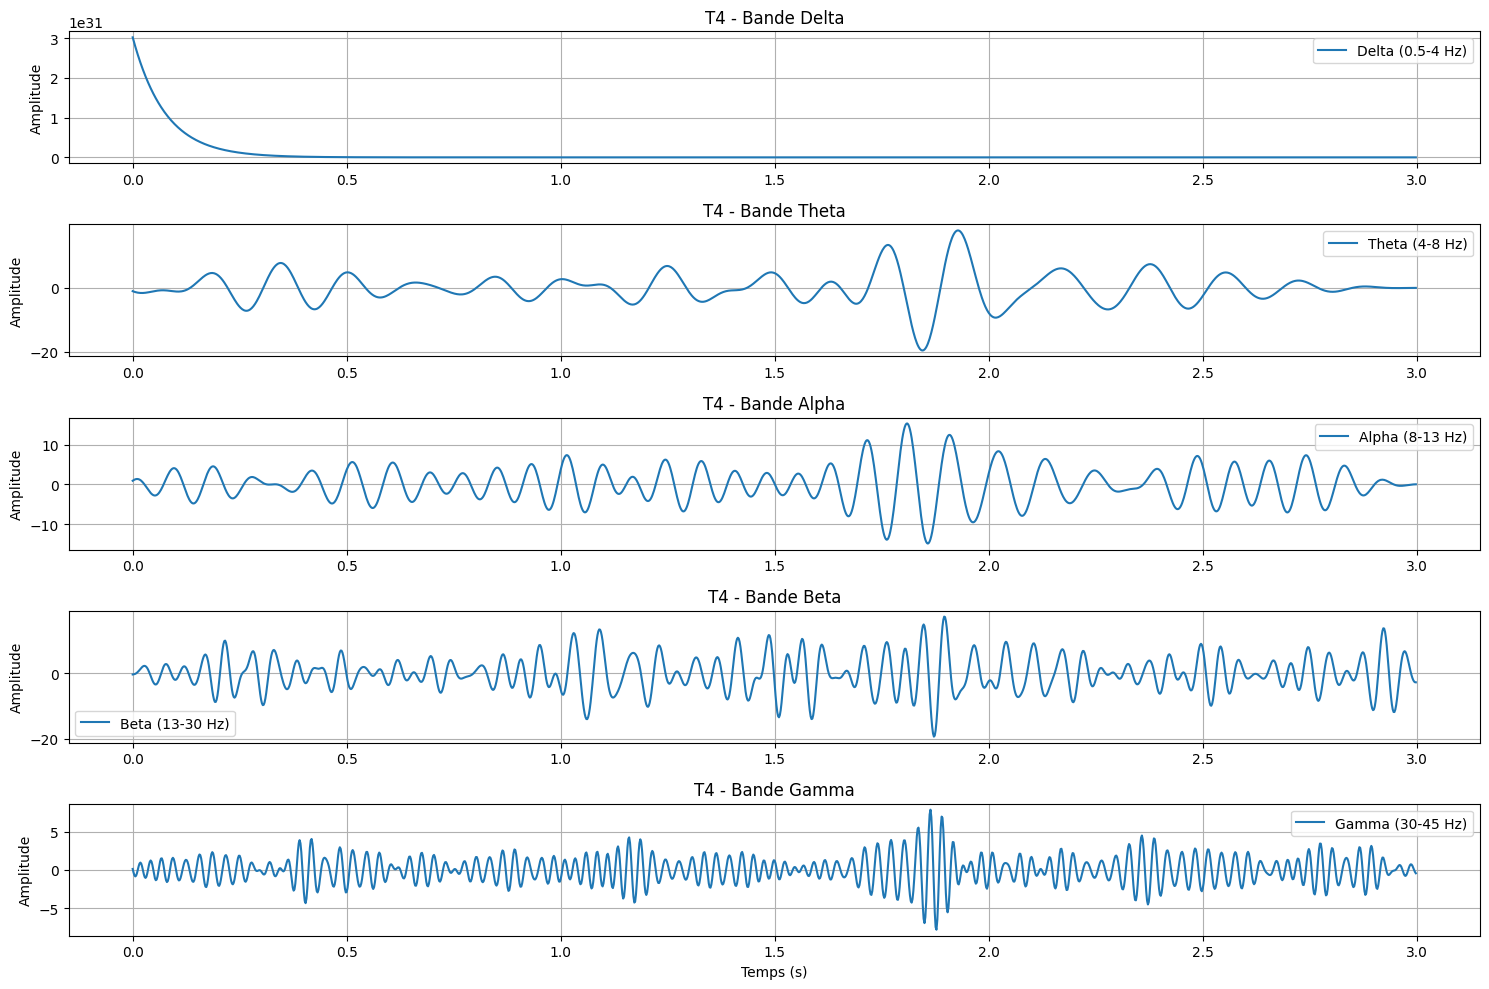

In [6]:
# ---- Visualisation du signal filtré par bande ----
n_seconds = 3
n_samples = n_seconds * sampling_rate
t = np.arange(n_samples) / sampling_rate

plt.figure(figsize=(15, 10))

for i, (band, (low, high)) in enumerate(bands.items()):
    filtered = bandpass_filter(signal[:n_samples], low, high, sampling_rate)
    plt.subplot(len(bands), 1, i + 1)
    plt.plot(t, filtered, label=f'{band} ({low}-{high} Hz)')
    plt.title(f'{channel} - Bande {band}')
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()

plt.xlabel("Temps (s)")
plt.tight_layout()
plt.show()

### Étape 2 : Construction des matrice de connectivité

À partir des signaux EEG filtrés dans une bande (ex : alpha), on veut construire une matrice wPLI (via MNE) et une matrice de cohérence.

In [8]:
# Exemple : data brute de forme (n_channels, n_times)
data = df[columns].values[:, :n_samples]

# Ajoute une dimension pour les époques → (1, n_channels, n_times)
epoch_data = np.expand_dims(data, axis=0)

# Calcul de la connectivité
from mne_connectivity import spectral_connectivity_epochs

con = spectral_connectivity_epochs(
    data=epoch_data,
    method=["wpli"],
    sfreq=500,
    fmin=131.579,
    fmax=200,
    faverage=True,
    verbose=False
)

# Connectome en 2D
connectivity_matrix = con.get_data(output="dense")[:, :, 0]


: 

### Intéressant mais le visuel est bof...